# Read in data and set up plotting

In [1]:
import pandas as pd
import numpy as np
import ast
from print_versions import print_versions
from joblib import Parallel, delayed
from scipy.spatial.distance import pdist, cdist
from sklearn.metrics.pairwise import cosine_similarity
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import permutation
import random
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from numpy import std, mean, sqrt
import itertools
from numpy.random import permutation
import os
import random
import pickle 
random.seed(416)
np.random.seed(416)

print("IMPORTANT INFO")
print("=="*5)
print(f"This script uses these package versions")
print_versions(globals())
print("=="*5)

def make_aesthetic(hex_color_list=None):
    """Make Seaborn look clean"""
    sns.set(style='white', context='poster', font_scale=1)
    if not hex_color_list:
        hex_color_list = [
            "#826AED",  # Medium slate blue
            "#00A896",  # Persian green
            "#D41876",  # Telemagenta
            "#89DAFF",  # Pale azure
            "#F7B2AD",  # Melon
            "#342E37",  # Dark grayish-purple
            "#7DCD85",  # Emerald
            "#E87461",  # Medium-bright orange
            "#E3B505",  # Saffron
            "#2C3531",  # Dark charcoal gray with a green undertone
            "#D4B2D8",  # Pink lavender
            "#7E6551",  # Coyote
            "#F45B69",  # Vibrant pinkish-red
            "#020887",  # Phthalo Blue
            "#F18805"  # Tangerine
        ]
    sns.set_palette(sns.color_palette(hex_color_list))
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.titlelocation'] = 'left'
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.alpha'] = 0.5
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['legend.framealpha'] = 0.8
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['savefig.transparent'] = False
    plt.rcParams['savefig.bbox'] = 'tight'
    plt.rcParams['savefig.pad_inches'] = 0.1
    plt.rcParams['figure.autolayout'] = True


make_aesthetic()


def clean_condition_col(x):
    if x == "f_l":
        return "LowExposure\nLabeled"
    elif x == "f_u":
        return "LowExposure\nUnlabeled"
    elif x == "m_l":
        return "HiExposure\nLabeled"
    elif x == "m_u":
        return "HiExposure\nUnlabeled"
    elif x == "h":
        return "HumanControl"


df = pd.read_csv("../../data/experiment_data/data_clean.csv")
df['init_array'] = df['init_array'].apply(lambda x: eval(x)
                                          if isinstance(x, str) else x)
df['clean_condition'] = df['condition'].apply(lambda x: clean_condition_col(x))
df.tail()

IMPORTANT INFO
This script uses these package versions
pandas==2.2.1
numpy==1.26.4
joblib==1.3.2
scipy==1.12.0
seaborn==0.13.2
statsmodels==0.14.1


,Unnamed: 0,response_id,participant_id,response_text,response_date,condition,condition_order,item,response_chain,init_array,...,idea4_txt,idea_minus_excluded4_txt,idea5_txt,idea_minus_excluded5_txt,idea6_txt,idea_minus_excluded6_txt,source,trial_no,trial_no_excluded,clean_condition
3447,1664,8c3ca604-2ceb-4a73-a60a-c65ee70700c5,4f5b1ec5-c99d-400d-a59b-2adc74c1c111,Telescope,2023-07-27 15:25:38,m_u,0,bottle,6,"[ai_seed169, ai_seed49, f0ab3484-307b-4223-903...",...,glass bottle chandelier,glass bottle chandelier,bottle as a candle holder,bottle as a candle holder,Use broken bottle for TF2 Demoman Cosplay,Use broken bottle for TF2 Demoman Cosplay,Creative Mornings newsletter,20,20.0,HiExposure\nUnlabeled
3448,1456,a597c51b-d8f4-4398-99da-4071fb749aae,4f5b1ec5-c99d-400d-a59b-2adc74c1c111,Build playground for kids,2023-07-27 15:31:07,f_u,2,table,6,"[ai_seed1139, 942076ca-bf09-47ed-b53a-2e88f9fe...",...,table as a workout spot or as a prop for pract...,table as a workout spot or as a prop for pract...,Put upside down for pants holder,Put upside down for pants holder,hide people underneath it during a halloween e...,hide people underneath it during a halloween e...,Creative Mornings newsletter,17,17.0,LowExposure\nUnlabeled
3449,1338,5d352fa5-3dfd-4a2f-90ab-238860e67202,4f5b1ec5-c99d-400d-a59b-2adc74c1c111,Use it as a Float,2023-07-27 15:36:21,f_l,4,tire,6,"[a34f1b14-f7b0-47cf-af37-a9a4681175db, 23a6393...",...,decorative outdoor planter display stand,decorative outdoor planter display stand,fitness equipment for workouts,fitness equipment for workouts,Put some dirt in it and use it as an above-gro...,Put some dirt in it and use it as an above-gro...,Creative Mornings newsletter,19,19.0,LowExposure\nLabeled
3450,1645,41910259-807c-4c15-89e4-a55049d60811,05ae6ec0-719e-405b-8616-09c921ba02e5,REPURPOSE IT AS A PIECE OF ART ON YOUR WALL,2023-07-27 16:03:47,m_u,0,table,6,"[ai_seed995, ai_seed988, ai_seed1132, ai_seed1...",...,tabletop sand zen garden,tabletop sand zen garden,use it as a stage to perform from,use it as a stage to perform from,Base for a giant fishtank,Base for a giant fishtank,share,16,16.0,HiExposure\nUnlabeled
3451,1298,0bc18504-e158-4c8a-a6ee-3fdf282a590f,05ae6ec0-719e-405b-8616-09c921ba02e5,chandelier light,2023-07-27 16:10:42,h,3,bottle,6,"[462e511a-e9c0-4b0d-8f24-f74bc928cd73, def05ef...",...,use it as a musical instrument,use it as a musical instrument,I could bottle my hopes in a store-bought scen...,I could bottle my hopes in a store-bought scen...,Paint it and use as a piece for a stained glas...,Paint it and use as a piece for a stained glas...,share,20,20.0,HumanControl


In [2]:
# In R, the final dataset has 3414 observations. Let's make sure all missing data is accounted for: 3414 should be |full data| - sum(exclude from analysis):
r_data = 3414
full_n = len(df)
accounted_for_exclusions =  np.sum(df['exclude_from_analysis'])

if full_n - accounted_for_exclusions == r_data:
    print("SUCCESS: We are all good: all missing data is accounted for in the exclude_from_analysis column") 
else:
    print("FAIL: Alert! Somewhere along the way we lost some data!!!")

SUCCESS: We are all good: all missing data is accounted for in the exclude_from_analysis column


# Get embeding of all ideas

The goal is to get a hash map `idea2vec` where key is text and value is sbert vector

In [3]:
def get_idea2vec(tdf):
    idea2vec_fn = "idea2vec.pickle"
    if not os.path.exists(idea2vec_fn):
        from sentence_transformers import SentenceTransformer
        model = SentenceTransformer('all-MiniLM-L12-v2')

        # Get a list of all ideas
        example_cols = [x for x in tdf.columns if "_txt" in x and "excluded" not in x]
        tdf['init_array_list'] = tdf[example_cols].values.tolist()
        all_ideas = []
        all_ideas.extend(tdf['response_text'])
        for x in example_cols:
            all_ideas.extend(tdf[x].to_list())
        all_ideas = list(set(all_ideas))
        all_ideas = [x for x in all_ideas] 
        
        # Get embeddings and create idea2vec mapping --> save to pickle
        embeddings = model.encode(all_ideas)
        idea2vec = dict(zip(all_ideas, embeddings))
        with open('idea2vec.pickle', 'wb') as f:
            pickle.dump(idea2vec, f)
        return tdf, idea2vec
    else:
        example_cols = [x for x in tdf.columns if "_txt" in x and "excluded" not in x]
        tdf['init_array_list'] = tdf[example_cols].values.tolist()
        with open('idea2vec.pickle', 'rb') as f:
            idea2vec = pickle.load(f)
        return tdf, idea2vec
df, idea2vec = get_idea2vec(df)

# Defune functions for inferential statistics



In [4]:
def cliffs_delta(x, y):
    n_x = len(x)
    n_y = len(y)
    n_greater = sum([1 for a in x for b in y if a > b])
    n_less = sum([1 for a in x for b in y if a < b])
    return (n_greater - n_less) / (n_x * n_y)



def process_metrics(mydf, grouping_var=None, plot_type='point', num_perm=10*1000):
    """
    Process the metrics for a dataframe. This handles all the analysis. When fed a dataframe it looks for columns containing
    `sim` or `dist` and analyzes them. _
    
    Foreach distance or similarity dv:
    
    1. Conduct a Kurskal Wallis test (akin to non-parametric ANOVA) to see if `dv` differs by condition. 
    2. Plot the distribution of `dv` by condition
    3. Conduct pairwise permutation tests (testing for a difference in means) and apply an FDR adjustment to p-values
    
    Params
    - mydf: The dataframe
    - how ('boot', 'perm'): Either conduct a permutation test or feed in an already bootstrapped df 
    - paired (bool): Whether permutation test is on paired data
    - plot_type ('box', 'swarm', 'strip', 'bar', 'line', 'point'): Tye of plot
    """
    tables = []
    dist_metrics = [x for x in mydf.columns if "sim" in x or "dist" in x or "Distance" in x]
    print(dist_metrics)
    for dv in dist_metrics:
        plt.show()
        kruskal_wallis(mydf, "clean_condition", dv)
        pt = pairwise_tests(mydf, "clean_condition", dv, grouping_var, num_perm)
        display(pt)
        plot_distributions(mydf, "clean_condition", dv, plot_type)
        tables.append({dv:pt})
    return tables 


def plot_distributions(tdf, group_col, data_col, plot_type):
    # We have many graphs, need to have each condition mapped to consistent color
    # Let's make it so unlabeled is a lighter shade of labeled

    if data_col.startswith("ai"):
        tdf = tdf.query("condition != 'h'")
    else:
        pass

    if plot_type == "box":
        graph_func = sns.boxplot
    elif plot_type == "swarm":
        graph_func = sns.swarmplot
    elif plot_type == "strip":
        graph_func = sns.stripplot
    elif plot_type == 'bar':
        graph_func = sns.barplot
    elif plot_type == "line":
        graph_func = sns.lineplot
    elif plot_type == "point":
        graph_func = sns.pointplot
    else:
        raise ValueError(f"Unknown plot_type: {plot_type}")

    color_dict = {
        'Low Exposure\nDisclosed': '#826AED',
        'Low Exposure\nUndisclosed': '#C2B6F6',
        'Control': 'black',
        'High Exposure\nDisclosed': '#D41876',
        'High Exposure\nUndisclosed': '#F7B6D6',
    }
    

    data_col_clean = data_col.replace("_", " ").title()
    order = tdf.groupby(group_col)[data_col].mean().sort_values().index
    plt.figure(figsize=(15, 8))
    sns.pointplot(data=tdf,
               x=group_col,
               y=data_col,
               order=order,
               palette=color_dict,
               errorbar=('ci', 95))
    plt.xlabel("")
    plt.title(f"Global idea diversity measured by {data_col.lower()}\n(Error bars are 95% CIs)")
    plt.tight_layout()
    plt.savefig(f"{data_col.replace(' ', '_')}_global_div.png", dpi=400)
    plt.show()

def kruskal_wallis(tdf, group_col, data_col):
    """Kurskal Wallis test for non-parametric group differences"""
    if data_col.startswith("ai"):
        tdf = tdf[tdf['condition'] != 'h']
    H, p = stats.kruskal(
        *[group[data_col].values for name, group in tdf.groupby(group_col)])
    if p < 0.05:
        print(
            f"We conducted a Kruskal Wallis test and found {data_col} differed by {group_col}, H={np.round(H, 2)}, p={p}"
        )
    else:
        print(
            f"We conducted a Kruskal Wallis test and found {data_col} DID NOT DIFFER by {group_col}, H={np.round(H, 2)}, p={p}"
        )
    return H, p


def pairwise_tests(tdf, group_col, data_col, grouping_var=None, num_permutations=10*1000):
    """Conducts pairwise permutation tests with correction"""
    
    if data_col.startswith("ai"):
        tdf = tdf[tdf['condition'] != 'h']
        
    groups = tdf[group_col].unique()
    group_pairs = list(itertools.combinations(groups, 2))
    results = []

    for group1, group2 in group_pairs:
        group1_data = np.array(tdf[tdf[group_col] == group1][data_col])
        group2_data = np.array(tdf[tdf[group_col] == group2][data_col])

        p = perm_test_simple(group1_data, group2_data)  

        mean_diff = np.mean(group1_data) - np.mean(group2_data)
        pooled_sd = sqrt((group1_data.std()**2 + group2_data.std()**2) / 2)
        ef_size = mean_diff / pooled_sd
        delta = cliffs_delta(group1_data, group2_data)
        
        results.append([f"{group1}-{group2}", mean_diff, ef_size, delta, p])

    results_df = pd.DataFrame(results, columns=["Contrast", "Diff in Means", "d", "Cliff's Delta", "p"])
    reject, pvals_corrected, _, _ = multipletests(results_df['p'], method='holm')
    results_df['p_adj'] = pvals_corrected
    results_df['Reject Null'] = results_df['p_adj'].apply(lambda x: 'YES' if x < 0.05 else 'NO')
    results_df = results_df[[x for x in results_df.columns if x != "p"]]
    
    return results_df



def perm_test_simple(group_A, group_B, n_permutations=10000):
    """
    Perform a two-tailed paired permutation test for two groups A and B.
    """
    obs_diff = np.mean(group_A - group_B)
    diff_array = group_A - group_B
    num_extreme_values = 0
    for _ in range(n_permutations):
        np.random.seed(_)
        sign_flip = np.random.choice([-1, 1], len(diff_array))
        perm_diff = np.mean(diff_array * sign_flip)
        
        if abs(perm_diff) >= abs(obs_diff):
            num_extreme_values += 1
    
    # Compute p-value
    p_value = (num_extreme_values+1) / (n_permutations+1)
    
    return p_value



# Local Diversity 

This is about how the ideas that participants submitted related to the example ideas they saw. 


## Compute local diversity metrics.

In [5]:
def local_semantic_measures(row, idea2vec):
    example_list = row['init_array_list']
    example_rids = row['init_array']
    idea_vec = idea2vec[row['response_text']]

    ai_ideas = [
        example_list[i] for i in range(len(example_list))
        if "ai" in example_rids[i]
    ]
    human_ideas = [
        example for example, rid in zip(example_list, example_rids)
        if "ai" not in rid.lower()
    ]    
    example_vecs = [idea2vec[example] for example in example_list]
    ai_example_vecs = [idea2vec[example] for example in ai_ideas]
    human_example_vecs = [idea2vec[example] for example in human_ideas]
    distances_to_human_examples = cdist([idea_vec],human_example_vecs,metric='cosine')
    distances_to_examples = cdist([idea_vec],example_vecs,metric='cosine')

    # distance between idea_vec and centroid of example_vecs
    centroid = np.mean(example_vecs, axis=0)
    cent_dist = cdist([idea_vec], [centroid], metric='cosine')[0][0]
   
    # For the human condition, there are no ai ideas
    # so we replace metrics with nan if human
    if ai_example_vecs:
        distances_to_ai_examples = cdist([idea_vec],
                                         ai_example_vecs,
                                         metric='cosine')
        ai_max_sim = 1 - np.min(distances_to_ai_examples)

    else:
        distances_to_ai_examples = np.NaN
        ai_max_sim = np.NaN

    return pd.Series({
        'max_dist':np.max(distances_to_examples),
        'mean_dist':np.mean(distances_to_examples),
        'med_dist':np.median(distances_to_examples),
        'cent_dist': cent_dist,
        'ai_max_sim': ai_max_sim,
        'ai_mean_sim': np.mean(1-distances_to_ai_examples),
        'ai_med_sim': np.median(1-distances_to_ai_examples),


    })


# Don't look at things excluded from analysis
df = df.query("exclude_from_analysis==0")

# Add this column to count how many seeds are in example set
df['nt_seeds'] = df['init_array'].apply(lambda x: sum(1 for i in x if i.startswith("human_seed") or i.startswith("ai_seed")))
df['n_seeds'] = df['init_array'].apply(lambda x: sum(1 for i in x if i.startswith("human_seed")))

# Get semantic measures and save to df
semantic_measures_df = df.apply(lambda row: local_semantic_measures(row, idea2vec), axis=1)
df = pd.concat([df, semantic_measures_df], axis=1)
df = df.loc[:, ~df.columns.duplicated()]
df.to_csv("../../data/experiment_data/data_clean_with_elab_div_metrics.csv")

# Evolution of Semantic Divergence



In [6]:
def compute_embedding_metrics(X):
    center = np.mean(X, axis=0).reshape(1,-1)
    cent_dists = cdist(X, center, 'cosine')  
    dists = pdist(X, 'cosine')
    
    return pd.Series({
        'avg_pw_dist': np.mean(dists),
        'max_pw_dist': np.max(dists),
        'median_pw_dist': np.median(dists),
        'mean_cent_dist':np.mean(cent_dists)
    })


ag_df = df.copy()
aggregated_ideas = ag_df.groupby(by=['trial_no', 'condition', 'item'])['response_text'].agg(list).reset_index()
aggregated_ideas['vectors'] = aggregated_ideas['response_text'].apply(lambda x: np.vstack([idea2vec[i] for i in x]))
aggregated_ideas['nobs'] = aggregated_ideas['response_text'].apply(lambda x: len(x))
aggregated_ideas = aggregated_ideas.query("nobs>1")
aggregated_ideas['vectors'] = aggregated_ideas['response_text'].apply(lambda x: np.vstack([idea2vec[i] for i in x]))
embedding_metrics = aggregated_ideas['vectors'].apply(compute_embedding_metrics)
aggregated_ideas = pd.concat([aggregated_ideas, embedding_metrics], axis=1)
aggregated_ideas.to_csv("../../data/experiment_data/ag_time.csv")

# Global Diversity Metrics

['Mean Pairwise Distance', 'Median Pairwise Distance', 'Mean Centroid Distance']
We conducted a Kruskal Wallis test and found Mean Pairwise Distance differed by clean_condition, H=78.51, p=3.6086388263791675e-16


,Contrast,Diff in Means,d,Cliff's Delta,p_adj,Reject Null
0,Control-High Exposure\nDisclosed,-1.339784,-0.690386,-0.354336,0.001000,YES
1,Control-High Exposure\nUndisclosed,-0.903009,-0.396967,-0.272256,0.001000,YES
2,Control-Low Exposure\nDisclosed,-0.339664,-0.205770,-0.090176,0.011099,YES
3,Control-Low Exposure\nUndisclosed,0.457457,0.193566,0.024416,0.016498,YES
4,High Exposure\nDisclosed-High Exposure\nUndisc...,0.436774,0.181839,0.045568,0.011099,YES
5,High Exposure\nDisclosed-Low Exposure\nDisclosed,1.000120,0.548908,0.288032,0.001000,YES
6,High Exposure\nDisclosed-Low Exposure\nUndiscl...,1.797241,0.722944,0.321024,0.001000,YES
7,High Exposure\nUndisclosed-Low Exposure\nDiscl...,0.563345,0.259074,0.213024,0.001000,YES
8,High Exposure\nUndisclosed-Low Exposure\nUndis...,1.360466,0.493859,0.276256,0.001000,YES
9,Low Exposure\nDisclosed-Low Exposure\nUndisclosed,0.797121,0.351631,0.089408,0.001000,YES


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_63274/69155876.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data=tdf,


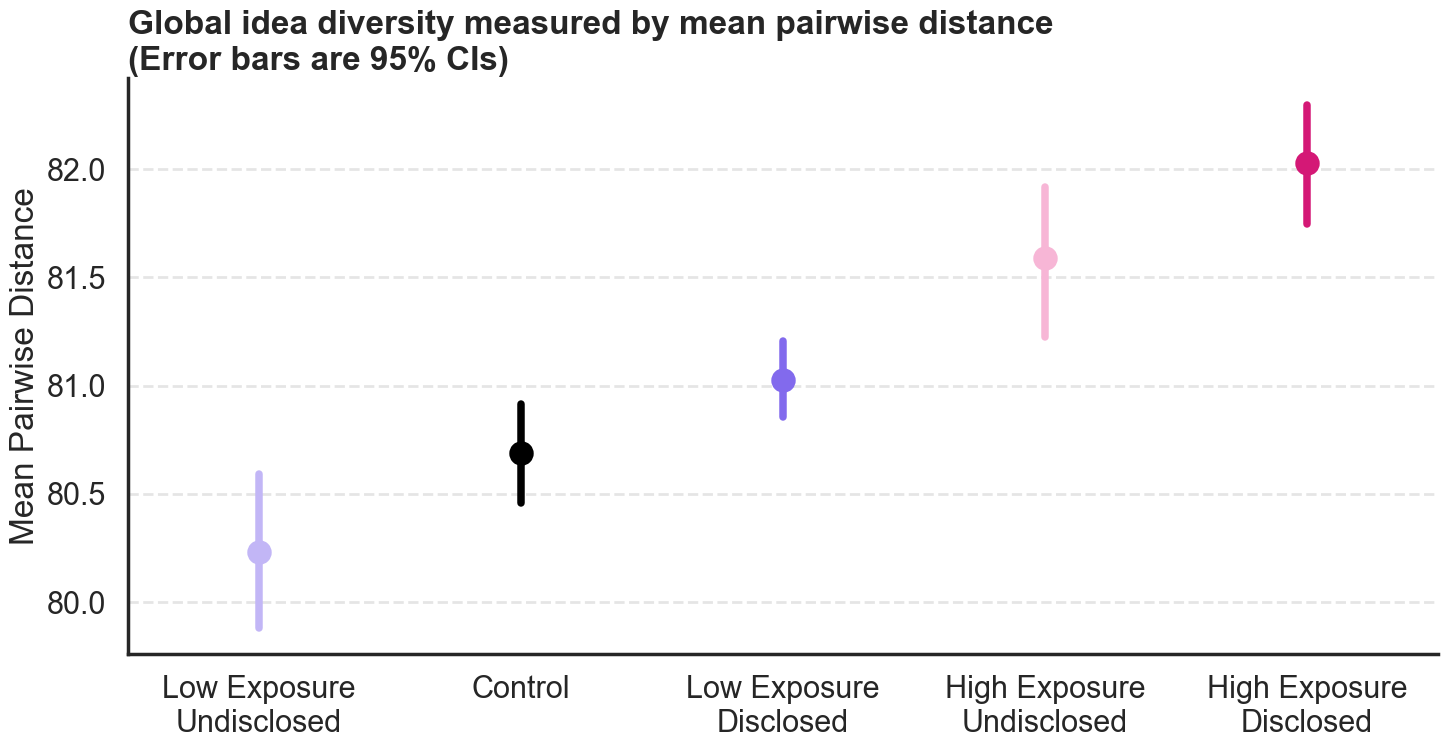

We conducted a Kruskal Wallis test and found Median Pairwise Distance differed by clean_condition, H=71.93, p=8.858192554101988e-15


,Contrast,Diff in Means,d,Cliff's Delta,p_adj,Reject Null
0,Control-High Exposure\nDisclosed,-1.212760,-0.596904,-0.314848,0.001000,YES
1,Control-High Exposure\nUndisclosed,-0.806261,-0.354061,-0.259616,0.001000,YES
2,Control-Low Exposure\nDisclosed,-0.472179,-0.282899,-0.114592,0.001000,YES
3,Control-Low Exposure\nUndisclosed,0.608694,0.248074,0.061568,0.006299,YES
4,High Exposure\nDisclosed-High Exposure\nUndisc...,0.406500,0.167040,0.040640,0.032797,YES
5,High Exposure\nDisclosed-Low Exposure\nDisclosed,0.740582,0.394596,0.232992,0.001000,YES
6,High Exposure\nDisclosed-Low Exposure\nUndiscl...,1.821455,0.700707,0.323968,0.001000,YES
7,High Exposure\nUndisclosed-Low Exposure\nDiscl...,0.334082,0.156107,0.180576,0.032797,YES
8,High Exposure\nUndisclosed-Low Exposure\nUndis...,1.414955,0.506159,0.287968,0.001000,YES
9,Low Exposure\nDisclosed-Low Exposure\nUndisclosed,1.080873,0.464492,0.150304,0.001000,YES


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_63274/69155876.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data=tdf,


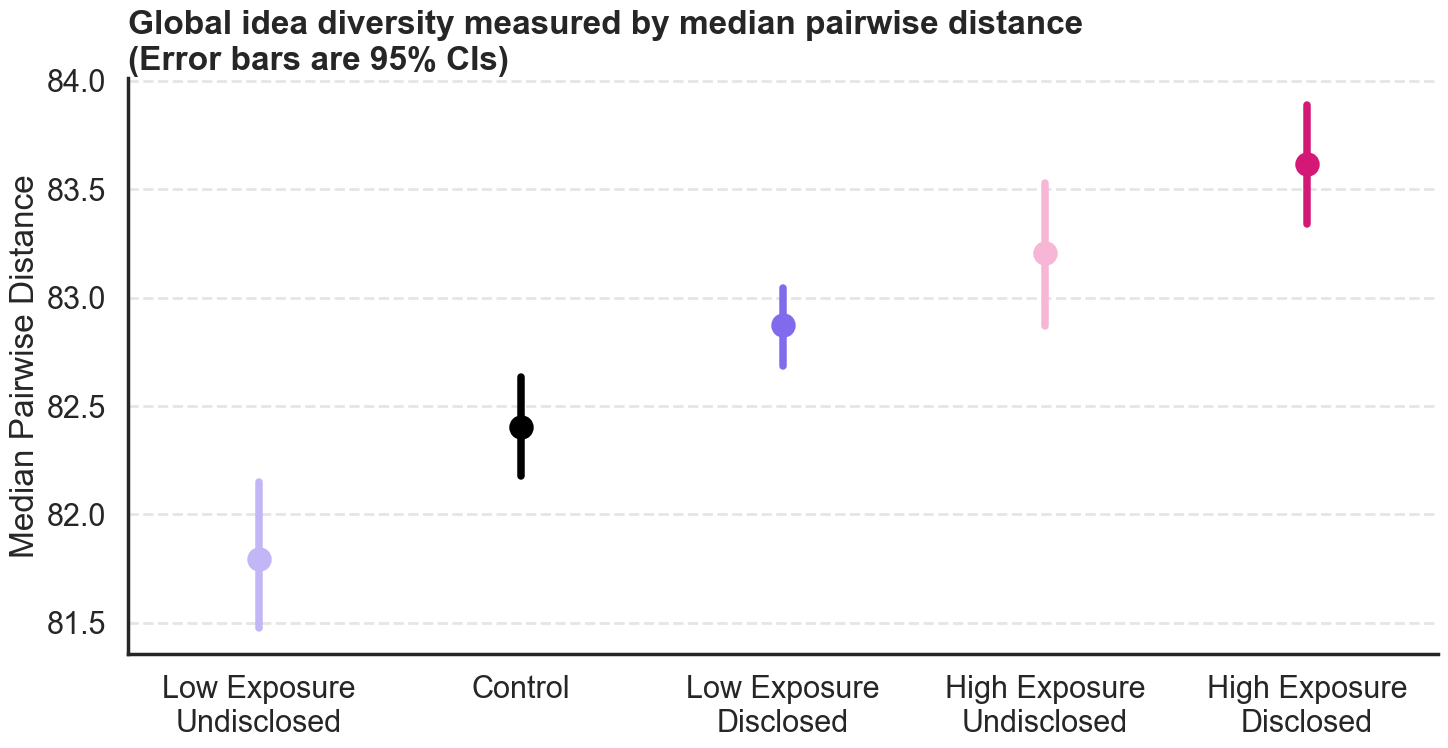

We conducted a Kruskal Wallis test and found Mean Centroid Distance differed by clean_condition, H=78.51, p=3.6086388263791675e-16


,Contrast,Diff in Means,d,Cliff's Delta,p_adj,Reject Null
0,Control-High Exposure\nDisclosed,-1.479952,-0.699262,-0.354336,0.001000,YES
1,Control-High Exposure\nUndisclosed,-1.031960,-0.422415,-0.272256,0.001000,YES
2,Control-Low Exposure\nDisclosed,-0.355396,-0.201243,-0.090176,0.013799,YES
3,Control-Low Exposure\nUndisclosed,0.430842,0.172854,0.024416,0.029497,YES
4,High Exposure\nDisclosed-High Exposure\nUndisc...,0.447992,0.170974,0.045568,0.013799,YES
5,High Exposure\nDisclosed-Low Exposure\nDisclosed,1.124557,0.561143,0.288032,0.001000,YES
6,High Exposure\nDisclosed-Low Exposure\nUndiscl...,1.910794,0.716599,0.321024,0.001000,YES
7,High Exposure\nUndisclosed-Low Exposure\nDiscl...,0.676564,0.288354,0.213024,0.001000,YES
8,High Exposure\nUndisclosed-Low Exposure\nUndis...,1.462802,0.498840,0.276256,0.001000,YES
9,Low Exposure\nDisclosed-Low Exposure\nUndisclosed,0.786238,0.327897,0.089408,0.001000,YES


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_63274/69155876.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data=tdf,


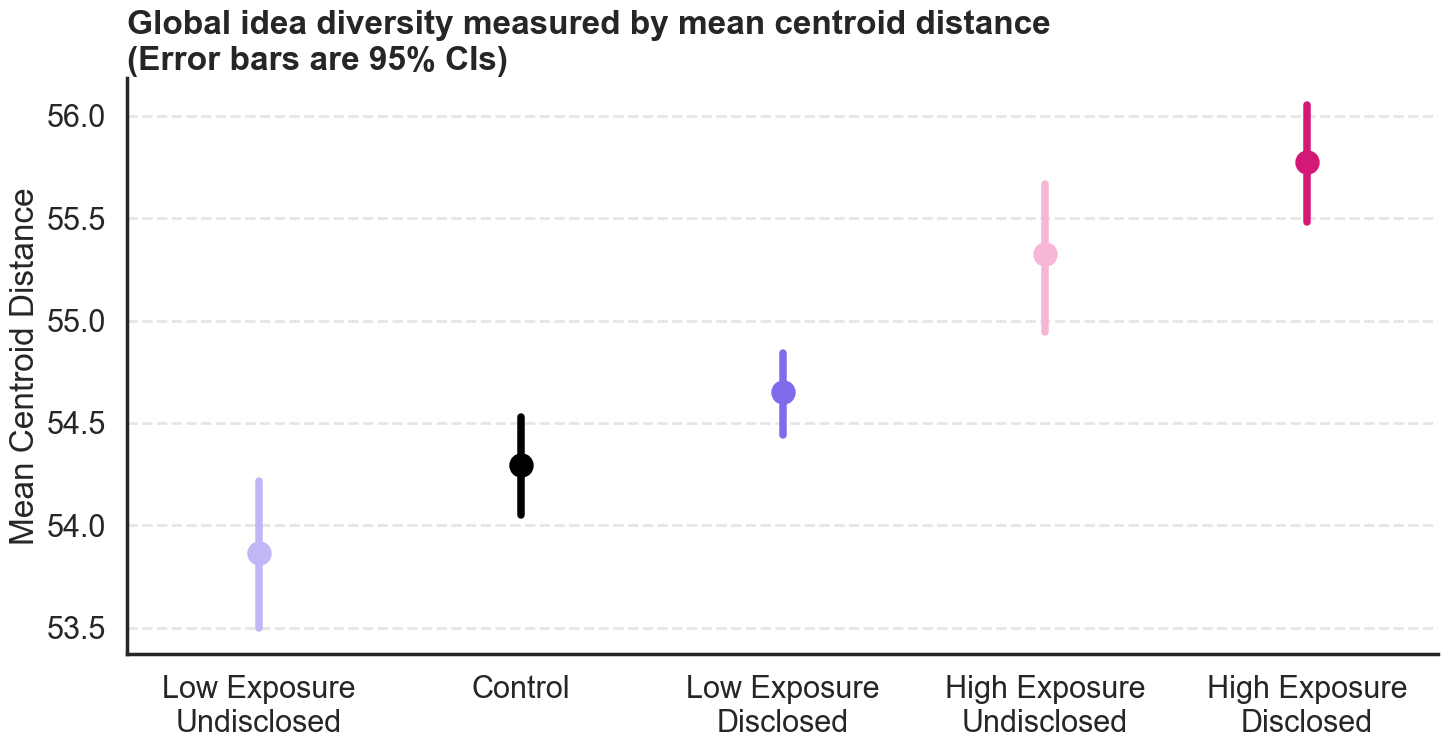

In [7]:
from scipy.spatial.distance import pdist, cosine
import numpy as np
import pandas as pd


def clean_condition_col(x):
    if x == "f_l":
        return "Low Exposure\nDisclosed"
    elif x == "f_u":
        return "Low Exposure\nUndisclosed"
    elif x == "m_l":
        return "High Exposure\nDisclosed"
    elif x == "m_u":
        return "High Exposure\nUndisclosed"
    elif x == "h":
        return "Control"

    
def compute_embedding_metrics(X):
    # Compute pairwise distances
    dists = pdist(X, 'cosine')
    centroid = np.mean(X, axis=0)
    centroid_dists = np.array([cosine(centroid, x) for x in X])
    
    return pd.Series({
        'Mean Pairwise Distance': 100*np.mean(dists),
        'Median Pairwise Distance': 100*np.median(dists),
        'Mean Centroid Distance': 100*np.mean(centroid_dists)  # added this line
    })

def process_iteration(tdf, seed):
    np.random.seed(seed)  # set seed for reproducibility
    tdf = tdf.groupby(by=['clean_condition', 'condition', 'item']).sample(n=50, random_state=seed)
    condition_ideas = tdf.groupby(by=['clean_condition', 'condition', 'item'])['response_text'].apply(lambda x: list(x)).reset_index()
    condition_ideas['vectors'] = condition_ideas['response_text'].apply(lambda x: np.vstack([idea2vec[i] for i in x]))
    embedding_metrics = condition_ideas['vectors'].apply(compute_embedding_metrics)
    condition_ideas = pd.concat([condition_ideas, embedding_metrics.apply(pd.Series)], axis=1)
    condition_ideas['seed'] = seed
    return condition_ideas

# Run the iterations in parallel using joblib
df['clean_condition'] = df['condition'].apply(lambda x: clean_condition_col(x))
df2 = df.query("trial_no > 6")
df2 = df2.sort_values(by=['response_date'])
embedding_results = Parallel(n_jobs=-1)(delayed(process_iteration)(df2, i) for i in range(50))
embedding_df = pd.concat(embedding_results)
tables = process_metrics(embedding_df)


In [10]:

# We want Control - Condition2 
def reverse_pairwise_comparisons(df, control_name='Control'):
    # Create a new DataFrame to store the reversed values
    reversed_df = df.copy()

    for idx, row in df.iterrows():
        contrast = row['Contrast']
        group1, group2 = contrast.split('-')
        
        # If the first group in the contrast is the control, reverse the contrast
        if group1 == control_name:
            reversed_contrast = f"{group2}-{group1}"
            reversed_df.loc[idx, 'Contrast'] = reversed_contrast
            reversed_df.loc[idx, 'Diff in Means'] = -row['Diff in Means']
            reversed_df.loc[idx, "Cliff's Delta"] = -row["Cliff's Delta"]

    return reversed_df

def process_table(t):

    dv = list(t.keys())[0]
    table = list(t.values())[0]
    table = table.drop(columns=["Reject Null", "d"]) # Cohen's d will ~overestimate~ fx size so report cliff's delta 
    table['Contrast'] = table['Contrast'].apply(lambda x: x.replace("\n", " "))
    table['Contrast'] = table['Contrast'].apply(lambda x: x.replace(" ", ""))
    table['p_adj'] = table['p_adj'].apply(lambda x: np.round(x,4))
    table['Diff in Means'] = table['Diff in Means'].apply(lambda x: np.round(x,2))
    table["Cliff's Delta"] = table["Cliff's Delta"].apply(lambda x: np.round(x,2))
    table = table[['Contrast', 'Diff in Means', 'p_adj', "Cliff's Delta"]]
    table = table.rename(columns = {"p_adj":"Adj P Value"})
    table = reverse_pairwise_comparisons(table)
    print(table.to_latex(label=f"global_{dv.lower().replace(' ', '_')}",
                     caption=f"Global idea diversity measured by {dv.lower()}"))

for i in range(len(tables)):
    process_table(tables[i])


\begin{table}
\caption{Global idea diversity measured by mean pairwise distance}
\label{global_mean_pairwise_distance}
\begin{tabular}{llrrr}
\toprule
 & Contrast & Diff in Means & Adj P Value & Cliff's Delta \\
\midrule
0 & HighExposureDisclosed-Control & 1.340000 & 0.001000 & 0.350000 \\
1 & HighExposureUndisclosed-Control & 0.900000 & 0.001000 & 0.270000 \\
2 & LowExposureDisclosed-Control & 0.340000 & 0.011100 & 0.090000 \\
3 & LowExposureUndisclosed-Control & -0.460000 & 0.016500 & -0.020000 \\
4 & HighExposureDisclosed-HighExposureUndisclosed & 0.440000 & 0.011100 & 0.050000 \\
5 & HighExposureDisclosed-LowExposureDisclosed & 1.000000 & 0.001000 & 0.290000 \\
6 & HighExposureDisclosed-LowExposureUndisclosed & 1.800000 & 0.001000 & 0.320000 \\
7 & HighExposureUndisclosed-LowExposureDisclosed & 0.560000 & 0.001000 & 0.210000 \\
8 & HighExposureUndisclosed-LowExposureUndisclosed & 1.360000 & 0.001000 & 0.280000 \\
9 & LowExposureDisclosed-LowExposureUndisclosed & 0.800000 & 0.001000